# **1. Installation des librairies**

In [48]:
!pip install captum
!pip install pytorch_lightning

# **2. Téléchargement du jeu de données de test**

In [30]:
!wget https://nextcloud.ig.umons.ac.be/s/XqEMQtqQNPoG2cY/download/test.zip
!unzip test.zip -d /test
!rm test.zip

--2024-11-21 21:37:14--  https://nextcloud.ig.umons.ac.be/s/XqEMQtqQNPoG2cY/download/test.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57038454 (54M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  54.40M  12.0MB/s    in 5.0s    

2024-11-21 21:37:20 (11.0 MB/s) - ‘test.zip’ saved [57038454/57038454]

Archive:  test.zip
replace /test/test/fire/F_1001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /test/test/fire/F_1001.jpg  
replace /test/test/fire/F_2062.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: B
error:  invalid response [B]
replace /test/test/fire/F_2062.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# **3. Importation des librarires**

In [49]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms.v2 as transforms
import torch.nn as nn
from captum.attr import LayerGradCam
import matplotlib.pyplot as plt
from torchvision import models
import pytorch_lightning as pl
import numpy as np
import cv2
from PIL import Image

# **4. Chargement des données : test_loader**

In [50]:
img_size = 224
testset_path  = "/test/test/"
batch_size = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

test_dataset = datasets.ImageFolder(testset_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# **5. Chargement du modèle**

In [51]:
class FireDetectionModel(pl.LightningModule):
    def __init__(self, model_name='resnet152', num_classes=3, learning_rate=0.01):
        super().__init__()

        self.model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(4096, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

model = FireDetectionModel.load_from_checkpoint("resnet152_best-checkpoint.ckpt")
model.eval()


FireDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

# **6. Application de la méthode XAI "GradCAM" sur la première image**

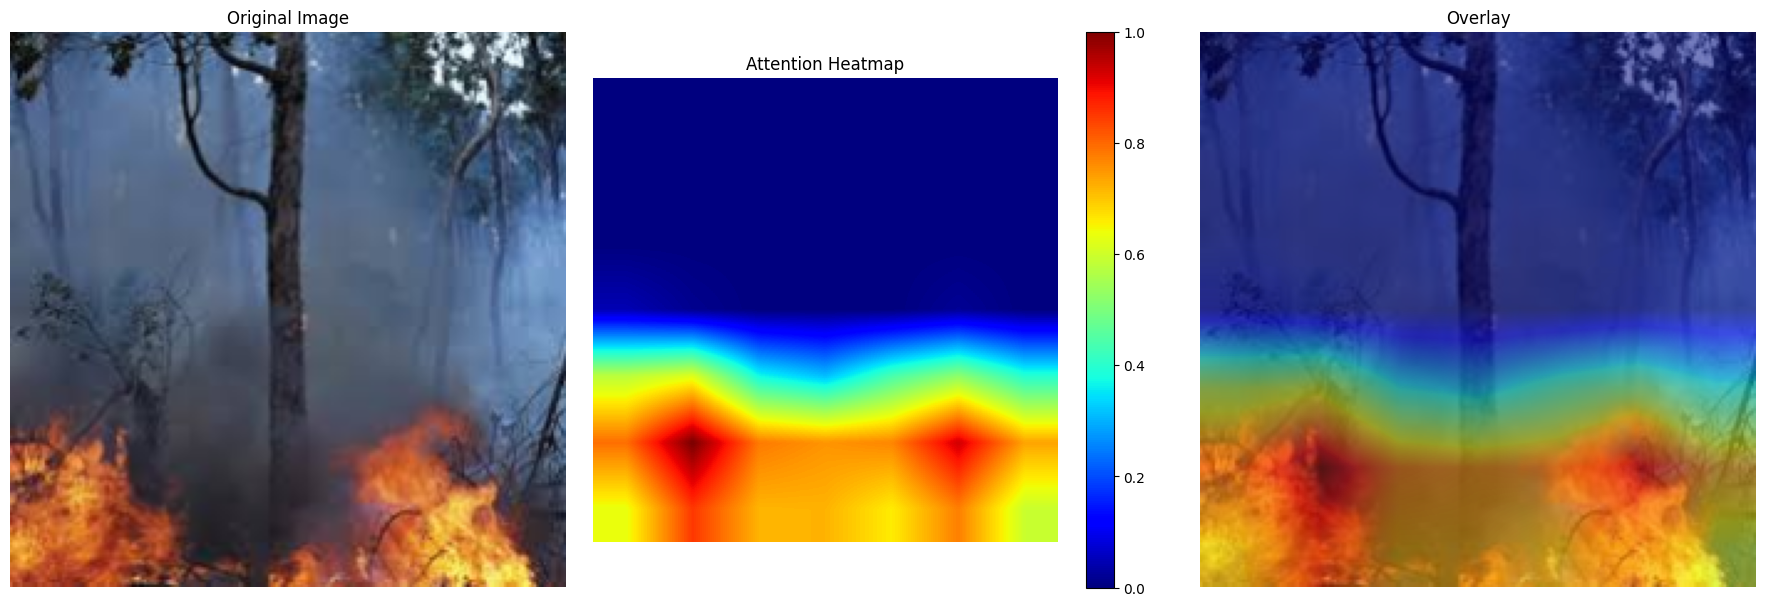

In [52]:
def get_last_conv_layer(model):
    last_conv_layer = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            last_conv_layer = module
    if last_conv_layer is None:
        raise ValueError("No Conv2d layer found in the model.")
    return last_conv_layer

def visualize_gradcam(model, inputs, labels, device, figsize=(18, 6)):
    # Get last convolutional layer
    last_conv_layer = get_last_conv_layer(model)
    gradcam = LayerGradCam(model, last_conv_layer)

    # Convert labels if necessary
    if isinstance(labels, torch.Tensor):
        labels = int(torch.argmax(labels.detach()).cpu().numpy())

    # Compute Grad-CAM attribution
    attribution = gradcam.attribute(inputs, target=labels, relu_attributions=True)

    # Convert tensors to numpy arrays
    attribution_np = attribution[0].cpu().detach().numpy()
    inputs_np = inputs[0].cpu().permute(1, 2, 0).detach().numpy()

    # Get original image dimensions
    height, width = inputs_np.shape[:2]

    # Resize attribution map to match input image size
    heatmap = cv2.resize(attribution_np[0], (width, height))

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Original image
    axes[0].imshow(inputs_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Heatmap only
    im = axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Attention Heatmap')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1])

    # Overlay
    axes[2].imshow(inputs_np)
    axes[2].imshow(heatmap, alpha=0.5, cmap='jet')
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    return fig

inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)

fig = visualize_gradcam(model, inputs, labels, device)
plt.show()

# Constatation:
On constate assez clairement que pour une image classée dans fire, la zone d'attention est sur le feu




# Maintenant regardons ce qu'il se passe avec des images des catégories start_fire et no_fire

In [53]:
from PIL import Image

# Fonction pour charger une image et appliquer les transformations
def load_image(image_path, img_size=224):
    image = Image.open(image_path).convert('RGB')  # Charger l'image
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),  # Redimensionner
        transforms.ToTensor(),  # Convertir en Tensor
    ])
    image_tensor = transform(image).unsqueeze(0)  # Ajouter une dimension batch
    return image_tensor

# Fonction pour afficher Grad-CAM pour une seule image
def visualize_gradcam_for_image(model, image_path, device, img_size=224, figsize=(18, 6)):
    # Charger l'image et la mettre sur le bon device
    inputs = load_image(image_path, img_size=img_size).to(device)

    # Récupérer la dernière couche convolutive
    last_conv_layer = get_last_conv_layer(model)
    gradcam = LayerGradCam(model, last_conv_layer)

    # Prédire la classe de l'image
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    label = predicted.item()

    # Appliquer Grad-CAM
    attribution = gradcam.attribute(inputs, target=label, relu_attributions=True)

    # Convertir les tensors en numpy pour affichage
    attribution_np = attribution[0].cpu().detach().numpy()
    inputs_np = inputs[0].cpu().permute(1, 2, 0).detach().numpy()

    # Obtenir les dimensions de l'image d'origine
    height, width = inputs_np.shape[:2]

    # Redimensionner la carte thermique pour correspondre à la taille de l'image d'entrée
    heatmap = cv2.resize(attribution_np[0], (width, height))

    # Normaliser la carte thermique
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    # Afficher les résultats
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Image originale
    axes[0].imshow(inputs_np)
    axes[0].set_title(f'Original Image (Class: {test_dataset.classes[label]})')
    axes[0].axis('off')

    # Carte thermique
    im = axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Attention Heatmap')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1])

    # Overlay de l'image originale et de la carte thermique
    axes[2].imshow(inputs_np)
    axes[2].imshow(heatmap, alpha=0.5, cmap='jet')
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

Avec une image start_fire nous constatons que la zone d'attention est la fumée, ce qui est bon signe et le modèle classe bien l'image dans start_fire

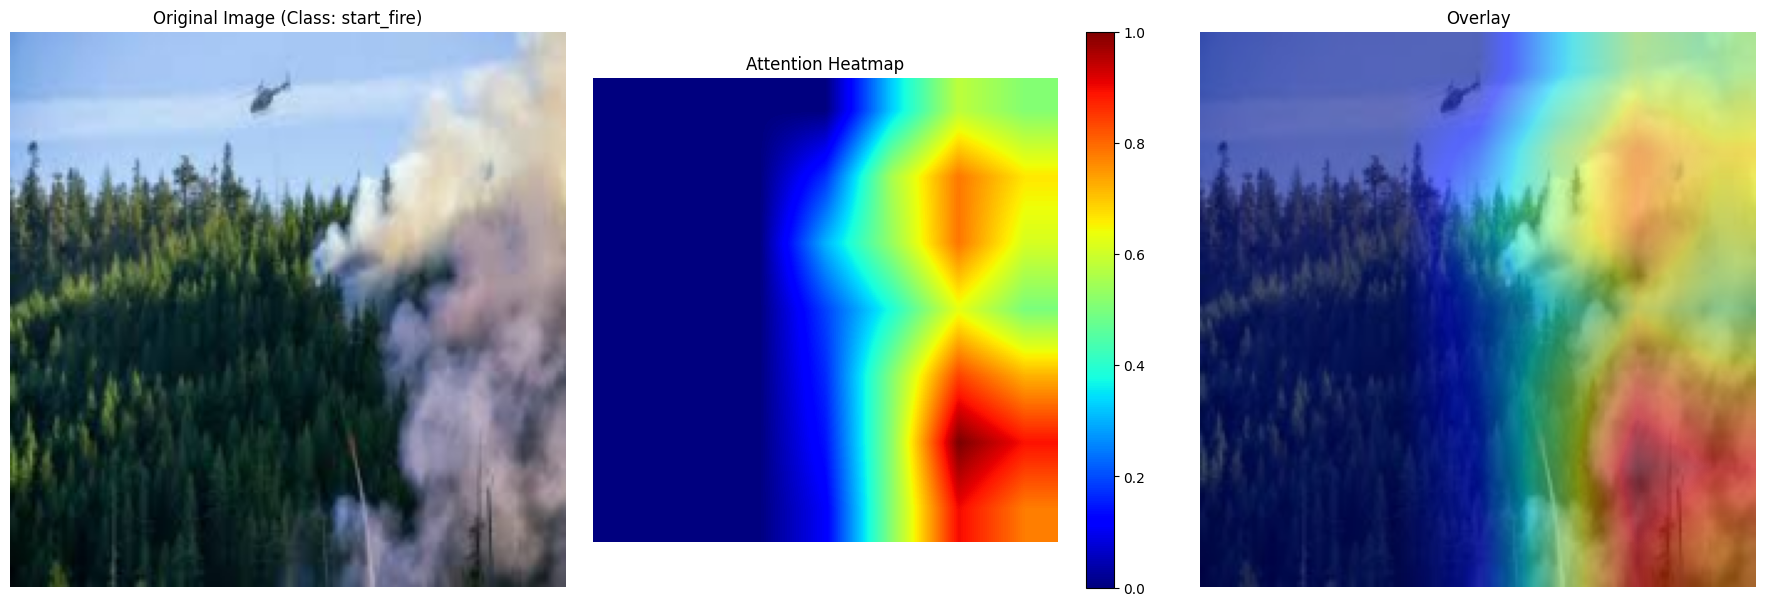

In [56]:
image_path = "start_fire_img.jpeg"
visualize_gradcam_for_image(model, image_path, device, img_size=224, figsize=(18, 6))